# Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports
import json
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data

## Read

In [3]:
route_str = 'B46'

In [4]:
read_segments = f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/Segment Data - Processed/{route_str}_2021-10-18.csv'
read_stops = f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/Route Data/{route_str}_stops.json'

In [5]:
route = pd.read_csv(read_segments)
route['timestamp'] = pd.to_datetime(route['timestamp'])

with open(read_stops, 'r') as f:
    stop_dict = json.load(f)
    stop_dict = {int(k): v for k, v in stop_dict.items()}

In [7]:
route.head()

,route,direction,trip_id,service_date,vehicle_id,timestamp,lat,lon,bearing,prior_stop_id,next_stop_id,next_stop_id_pos,next_stop_d_along_route,next_stop_est_sec,passenger_count
0,B46,1,MTA NYCT_FB_C1-Saturday-138700_B46_446,2021-07-31,MTA NYCT_7640,2021-08-01 00:00:56-04:00,40.646607,-73.929840,275.832550,MTA_308777,MTA_303690,35,8394.73,27.0,24.0
1,B46,0,MTA NYCT_FB_C1-Saturday-140800_B46_444,2021-07-31,MTA NYCT_7312,2021-08-01 00:01:00-04:00,40.679114,-73.929217,45.000000,MTA_308066,MTA_307092,33,7941.78,23.0,8.0
2,B46,0,MTA NYCT_FB_C1-Saturday-144000_B46_445,2021-07-31,MTA NYCT_7649,2021-08-01 00:01:55-04:00,40.611720,-73.924513,139.398710,MTA_300163,MTA_303590,3,676.65,99.0,0.0
3,B46,1,MTA NYCT_FB_C1-Saturday-138700_B46_446,2021-07-31,MTA NYCT_7640,2021-08-01 00:01:57-04:00,40.644874,-73.929649,276.391360,MTA_303690,MTA_303691,36,8609.88,25.0,24.0
4,B46,0,MTA NYCT_FB_C1-Saturday-140800_B46_444,2021-07-31,MTA NYCT_7312,2021-08-01 00:02:01-04:00,40.681071,-73.928692,101.481995,MTA_307092,MTA_303624,34,8215.23,21.0,8.0


## Feature Engineering

In [ ]:
# map cyclical components of timestamp (i.e. day of week and time of day) to numerical values
route['timestamp_DoW'] = route['timestamp'].dt.dayofweek
route['timestamp_sec_from_midnight'] = route['timestamp'].dt.time.apply(lambda x: (x.hour * 3600) + (x.minute * 60) + x.second + (x.microsecond / 1000000))

# encode cyclical features. reference: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca 
# normalize between 0 - 2pi
route['timestamp_DoW_norm'] = 2 * np.pi * route['timestamp_DoW'] / route['timestamp_DoW'].max()
route['timestamp_sec_from_midnight_norm'] = 2 * np.pi * route['timestamp_sec_from_midnight'] / route['timestamp_sec_from_midnight'].max()
route = route.drop(columns=['timestamp_DoW', 'timestamp_sec_from_midnight'])

# compute sin / cos 'coordinate' encodings; drop timestamp_DoW_norm
route['timestamp_DoW_sin'] = np.sin(route['timestamp_DoW_norm'])
route['timestamp_DoW_cos'] = np.cos(route['timestamp_DoW_norm'])
route['timestamp_sec_from_midnight_sin'] = np.sin(route['timestamp_sec_from_midnight_norm'])
route['timestamp_sec_from_midnight_cos'] = np.cos(route['timestamp_sec_from_midnight_norm'])
route = route.drop(columns=['timestamp_DoW_norm', 'timestamp_sec_from_midnight_norm'])

# Model

## Setup

In [ ]:
trip_id_bool = True

In [ ]:
route_ml = route.copy()

if trip_id_bool:
  route_ml = pd.get_dummies(route_ml, columns=['route', 'trip_id'])
  non_features =  ['service_date', 'vehicle_id', 'timestamp', 'prior_stop_id', 'next_stop_id', 'passenger_count']
else:
  route_ml = pd.get_dummies(route_ml, columns=['route'])
  non_features =  ['service_date', 'trip_id', 'vehicle_id', 'timestamp', 'prior_stop_id', 'next_stop_id', 'passenger_count']

## Train-Test Split

In [ ]:
# # random
# train, test = train_test_split(route_ml, test_size=0.2, random_state=0)

# # train: aug | test: sept
# train = route_ml.copy()
# test = route_ml.copy()
# train = train[train['timestamp'].dt.month == 8]
# test = test[test['timestamp'].dt.month == 9]

# train: days 0 to n-1 | test: day n
date = datetime.date(year=2021, month=9, day=27)
train = route_ml.copy()
test = route_ml.copy()
train = train[train['timestamp'].dt.date < date]
test = test[test['timestamp'].dt.date == date]

# # train: days 0 to n-1 | test: days >= n
# date = datetime.date(year=2021, month=9, day=17)
# train = route_ml.copy()
# test = route_ml.copy()
# train = train[train['timestamp'].dt.date < date]
# test = test[test['timestamp'].dt.date >= date]

In [ ]:
# compute average passenger_count by next_stop_id (using training only so as not to bake in information about the test set)
stop_stats = train[['next_stop_id', 'passenger_count']]
stop_stats = stop_stats.groupby('next_stop_id').agg({'passenger_count':['mean', 'std']})

train['avg_stop_passengers'] = train['next_stop_id'].apply(lambda x: stop_stats[('passenger_count', 'mean')].loc[x])
test['avg_stop_passengers'] = test['next_stop_id'].apply(lambda x: stop_stats[('passenger_count', 'mean')].loc[x])

In [ ]:
train_x = train.drop(columns=non_features)
train_y = train['passenger_count']

test_x = test.drop(columns=non_features)
test_y = test['passenger_count']

## Fit

In [ ]:
model = LassoCV().fit(train_x, train_y)

## Predict

In [ ]:
train_preds = model.predict(train_x)
test_preds = model.predict(test_x)

train['passenger_count_pred'] = train_preds
test['passenger_count_pred'] = test_preds

## Eval

In [ ]:
def is_crowded(stop_ids, passenger_counts, stop_stats, num_stds):
    crowded = []
    for (stop_id, passenger_count) in zip(stop_ids, passenger_counts):
      threshold = stop_stats[('passenger_count', 'mean')].loc[stop_id] + num_stds * stop_stats[('passenger_count', 'std')].loc[stop_id]
      if passenger_count > threshold:
        crowded.append(1)
      else:
        crowded.append(0)
    return crowded

In [ ]:
class Evaluation:
  def __init__(self, train=None, val=None, test=None, stop_dict=None, stop_stats=None):
    self.train = train
    self.val = val
    self.test = test
    self.stop_dict = stop_dict
    self.stop_stats = stop_stats
  
  def basic_eval(self, data, dir=None, segment=None):
    if data == 'train':
      df = self.train.copy()
    elif data == 'val':
      df = self.val.copy()
    elif data == 'test':
      df = self.test.copy()

    if dir:
      df = df[df['direction'] == dir]

    if segment:
      if type(segment) == str:
        next_stop_id = segment
        assert next_stop_id in set(self.stop_dict[dir])
        df = df[df['next_stop_id'] == next_stop_id]
      elif type(segment) == int:
        next_stop_id = self.stop_dict[dir][segment]
        df = df[df['next_stop_id'] == next_stop_id]

    gt = df['passenger_count']
    gt_mean = np.zeros_like(gt) + gt.mean()
    pred = df['passenger_count_pred']

    mae_pred = mean_absolute_error(gt, pred)
    max_error_pred = max_error(gt, pred)
    r2_pred = r2_score(gt, pred)

    mae_mean = mean_absolute_error(gt, gt_mean)
    max_error_mean = max_error(gt, gt_mean)
    r2_mean = r2_score(gt, gt_mean)

    print('Performance: Model Prediction')
    print(f'MAE: {mae_pred:.1f}')
    print(f'ME : {max_error_pred:.1f}')
    print(f'R^2: {r2_pred:.2f}')
    print('\n')
    print('Performance: Mean Prediction')
    print(f'MAE: {mae_mean:.1f}')
    print(f'ME : {max_error_mean:.1f}')
    print(f'R^2: {r2_mean:.2f}')
    
  def plot_passenger_count_by_time_of_day(self, data, dir=None, segment=None, agg='sum'):
    if data == 'train':
      df = self.train.copy()
    elif data == 'val':
      df = self.val.copy()
    elif data == 'test':
      df = self.test.copy()

    if dir:
      df = df[df['direction'] == dir]

    if segment:
      if type(segment) == str:
        next_stop_id = segment
        assert next_stop_id in set(self.stop_dict[dir])
        df = df[df['next_stop_id'] == next_stop_id]
      elif type(segment) == int:
        next_stop_id = self.stop_dict[dir][segment]
        df = df[df['next_stop_id'] == next_stop_id]

    hours = list(range(24))
    df['day_type'] = df['timestamp'].apply(lambda x: 'weekday' if x.dayofweek < 5 else 'weekend')

    if agg == 'sum':
      gt = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count'].sum().unstack()
      pred = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count_pred'].sum().unstack()

      if ('weekday' in set(gt.columns)) and ('weekday' in set(pred.columns)):
        gt_weekday = gt['weekday']
        pred_weekday = pred['weekday']

        plt.figure(figsize=(20, 10))
        plt.plot(gt.index, gt_weekday, label='Ground Truth', color='darkorange')
        plt.plot(pred.index, pred_weekday, label='Prediction', color='navy')
        plt.xticks(hours)
        plt.xlabel('Time of Day')
        plt.ylabel('Passenger Count')
        plt.title('Weekday')
        plt.legend()
        plt.show()

      if ('weekend' in set(gt.columns)) and ('weekend' in set(pred.columns)):  
        gt_weekend = gt['weekend']
        pred_weekend = pred['weekend']

        plt.figure(figsize=(20, 10))
        plt.plot(gt.index, gt_weekend, label='Ground Truth', color='darkorange')
        plt.plot(pred.index, pred_weekend, label='Prediction', color='navy')
        plt.xticks(hours)
        plt.xlabel('Time of Day')
        plt.ylabel('Passenger Count')
        plt.title('Weekend')
        plt.legend()
        plt.show()
      
    elif agg == 'mean':
      gt_avg = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count'].mean().unstack()
      gt_std = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count'].std().unstack()
      pred_avg = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count_pred'].mean().unstack()
      pred_std = df.groupby([df['timestamp'].dt.hour, 'day_type'])['passenger_count_pred'].std().unstack()

      if (('weekday' in set(gt_avg.columns)) and ('weekday' in set(gt_std.columns))) and (('weekday' in set(pred_avg.columns)) and ('weekday' in set(pred_std.columns))):
        gt_weekday_avg = gt_avg['weekday']
        gt_weekday_std = gt_std['weekday']
        pred_weekday_avg = pred_avg['weekday']
        pred_weekday_std = pred_std['weekday']
        plt.figure(figsize=(20, 10))
        plt.plot(gt_avg.index, gt_weekday_avg, label='Ground Truth', color='darkorange')
        plt.fill_between(gt_avg.index, gt_weekday_avg - gt_weekday_std, gt_weekday_avg + gt_weekday_std, alpha=0.2, color='darkorange', lw=2)
        plt.plot(pred_avg.index, pred_weekday_avg, label='Prediction', color='navy')
        plt.fill_between(pred_avg.index, pred_weekday_avg - pred_weekday_std, pred_weekday_avg + pred_weekday_std, alpha=0.2, color='navy', lw=2)
        plt.xticks(hours)
        plt.xlabel('Time of Day')
        plt.ylabel('Passenger Count')
        plt.title('Weekday')
        plt.legend()
        plt.show()

      if (('weekend' in set(gt_avg.columns)) and ('weekend' in set(gt_std.columns))) and (('weekend' in set(pred_avg.columns)) and ('weekend' in set(pred_std.columns))):  
        gt_weekend_avg = gt_avg['weekend']
        gt_weekend_std = gt_std['weekend']
        pred_weekend_avg = pred_avg['weekend']
        pred_weekend_std = pred_std['weekend']
        plt.figure(figsize=(20, 10))
        plt.plot(gt_avg.index, gt_weekend_avg, label='Ground Truth', color='darkorange')
        plt.fill_between(gt_avg.index, gt_weekend_avg - gt_weekend_std, gt_weekend_avg + gt_weekend_std, alpha=0.2, color='darkorange', lw=2)
        plt.plot(pred_avg.index, pred_weekend_avg, label='Prediction', color='navy')
        plt.fill_between(pred_avg.index, pred_weekend_avg - pred_weekend_std, pred_weekend_avg + pred_weekend_std, alpha=0.2, color='navy', lw=2)
        plt.xticks(hours)
        plt.xlabel('Time of Day')
        plt.ylabel('Passenger Count')
        plt.title('Weekend')
        plt.legend()
        plt.show()

  def gt_pred_scatter(self, data, dir=None, eps=0.1, s=2, lower=None, upper=None):
    if data == 'train':
      df = self.train.copy()
    elif data == 'val':
      df = self.val.copy()
    elif data == 'test':
      df = self.test.copy()

    df = df[df['direction'] == dir]
    stop_ids_route = self.stop_dict[dir]
    stop_pos_route = list(range(len(stop_ids_route)))

    df['pred_to_gt_ratio'] = (df['passenger_count_pred'] + eps) / (df['passenger_count'] + eps)

    plt.figure(figsize=(20, 10))

    # model predictions too high (plot gt markers on top of pred markers)
    over_est_df = df[df['pred_to_gt_ratio'] >= 1]
    over_est_stop_pos_obs = over_est_df['next_stop_id_pos']
    over_est_gt = over_est_df['passenger_count']
    over_est_ratios = over_est_df['pred_to_gt_ratio']
    over_est_ratios = over_est_ratios.clip(lower=lower, upper=upper)
    over_est_ss = [s * ratio ** 2 for ratio in over_est_ratios]
    plt.scatter(over_est_stop_pos_obs, over_est_gt, s=over_est_ss, marker='o', label='Prediction', color='navy')
    plt.scatter(over_est_stop_pos_obs, over_est_gt, s=s, marker='o', label='Ground Truth', color='darkorange')

    # model predictions too low (plot pred markers on top of gt markers)
    under_est_df = df[df['pred_to_gt_ratio'] < 1]
    under_est_stop_pos_obs = under_est_df['next_stop_id_pos']
    under_est_gt = under_est_df['passenger_count']
    under_est_ratios = under_est_df['pred_to_gt_ratio']
    under_est_ratios = under_est_ratios.clip(lower=lower, upper=upper)
    under_est_ss = [s * ratio ** 2 for ratio in under_est_ratios]
    plt.scatter(under_est_stop_pos_obs, under_est_gt, s=s, marker='o', color='darkorange')
    plt.scatter(under_est_stop_pos_obs, under_est_gt, s=under_est_ss, marker='o', color='navy')

    plt.xticks(stop_pos_route, stop_ids_route, rotation=90)
    plt.xlabel('Stop')
    plt.ylabel('Ground Truth Passenger Count')
    legend = plt.legend()
    for handle in legend.legendHandles:
      handle.set_sizes([s])
    plt.show()


  def print_classification_metrics(self, data, dir=None, segment=None, num_stds=1):
    if data == 'train':
      df = self.train.copy()
    elif data == 'val':
      df = self.val.copy()
    elif data == 'test':
      df = self.test.copy()

    if dir:
      df = df[df['direction'] == dir]

    if segment:
      if type(segment) == str:
        next_stop_id = segment
        assert next_stop_id in set(self.stop_dict[dir])
        df = df[df['next_stop_id'] == next_stop_id]
      elif type(segment) == int:
        next_stop_id = self.stop_dict[dir][segment]
        df = df[df['next_stop_id'] == next_stop_id]
    
    gt_crowded = is_crowded(df['next_stop_id'], df['passenger_count'], self.stop_stats, num_stds)
    pred_crowded = is_crowded(df['next_stop_id'], df['passenger_count_pred'], self.stop_stats, num_stds)

    print('Classification Report:')
    print(classification_report(gt_crowded, pred_crowded))
    print('\n')
    print('Confusion Matrix (0 = not crowded | 1 = crowded):')
    print(confusion_matrix(gt_crowded, pred_crowded))


In [ ]:
eval = Evaluation(train=train, test=test, stop_dict=stop_dict, stop_stats=stop_stats)

In [ ]:
eval.basic_eval('train')

Performance: Model Prediction
MAE: 5.8
ME : 84.3
R^2: 0.31


Performance: Mean Prediction
MAE: 7.2
ME : 79.5
R^2: 0.00


In [ ]:
eval.basic_eval('test')

Performance: Model Prediction
MAE: 5.7
ME : 42.0
R^2: 0.30


Performance: Mean Prediction
MAE: 7.5
ME : 42.3
R^2: 0.00


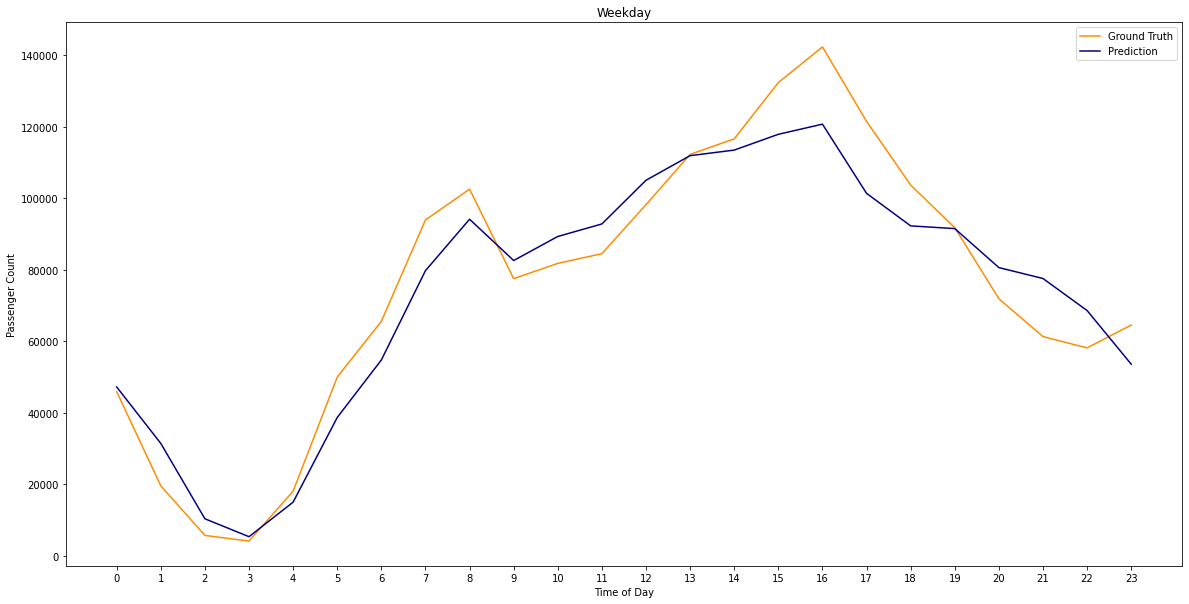

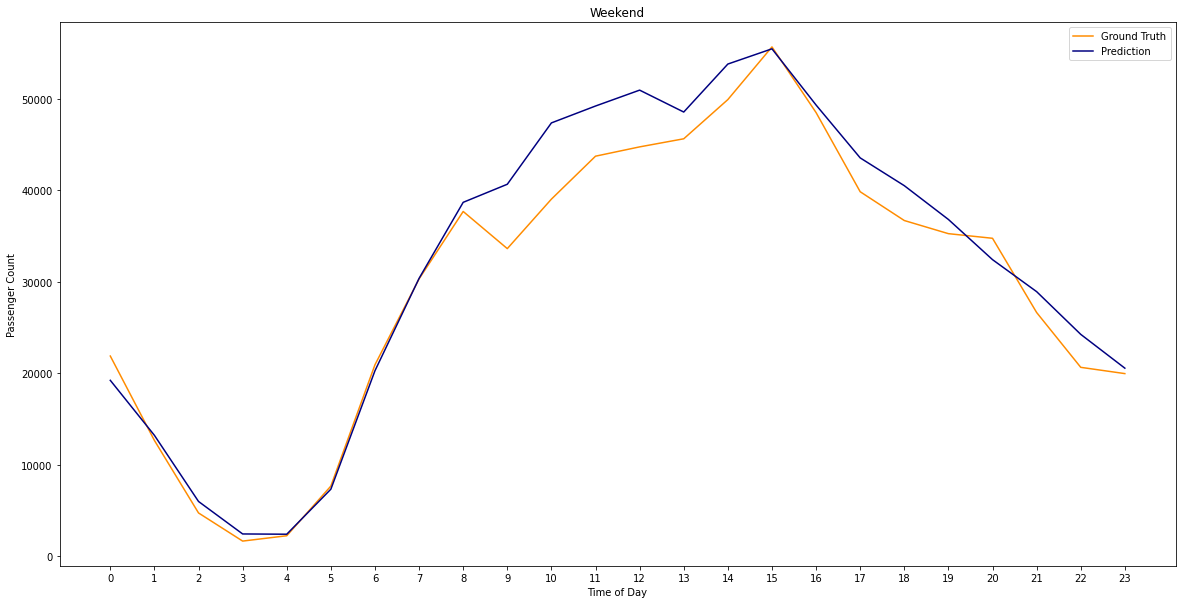

In [ ]:
eval.plot_passenger_count_by_time_of_day('train', dir=None, segment=None, agg='sum')

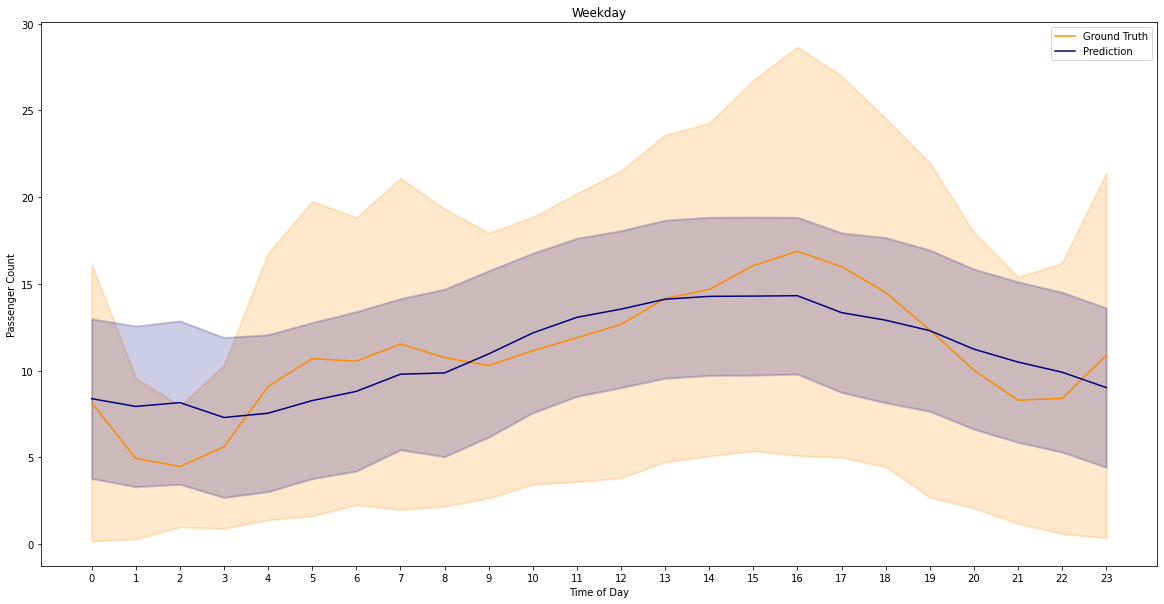

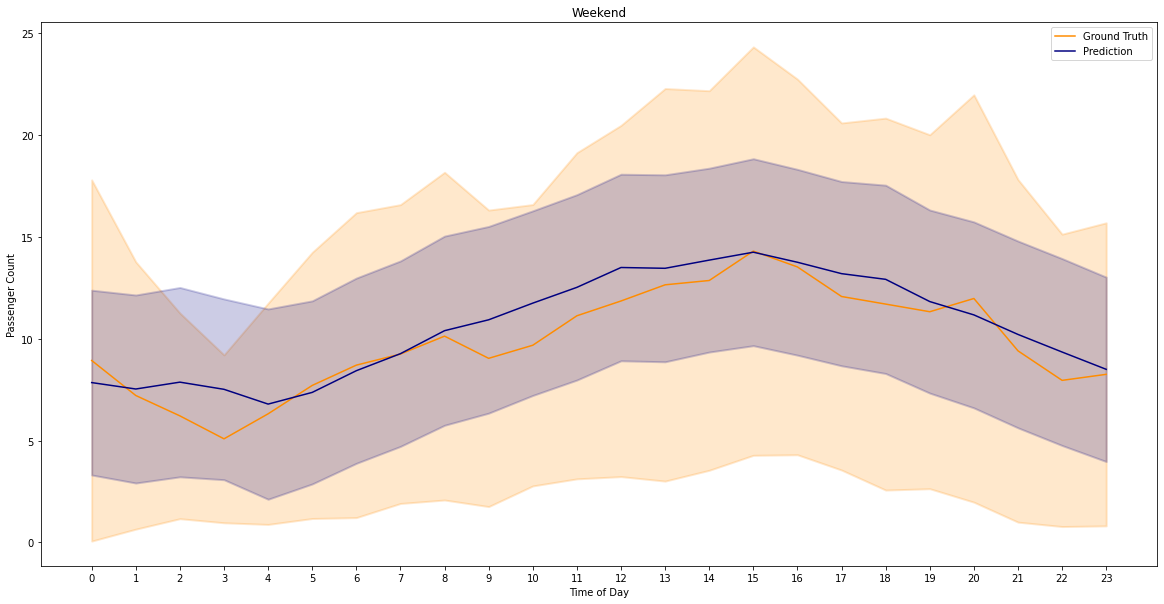

In [ ]:
eval.plot_passenger_count_by_time_of_day('train', dir=None, segment=None, agg='mean')

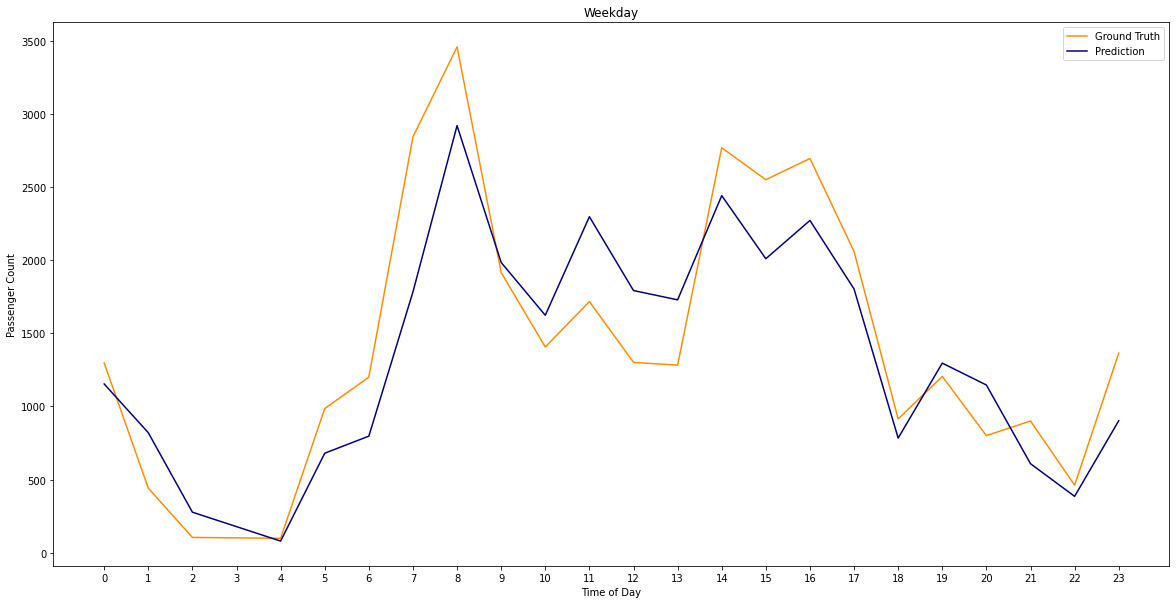

In [ ]:
eval.plot_passenger_count_by_time_of_day('test', dir=None, segment=None, agg='sum')

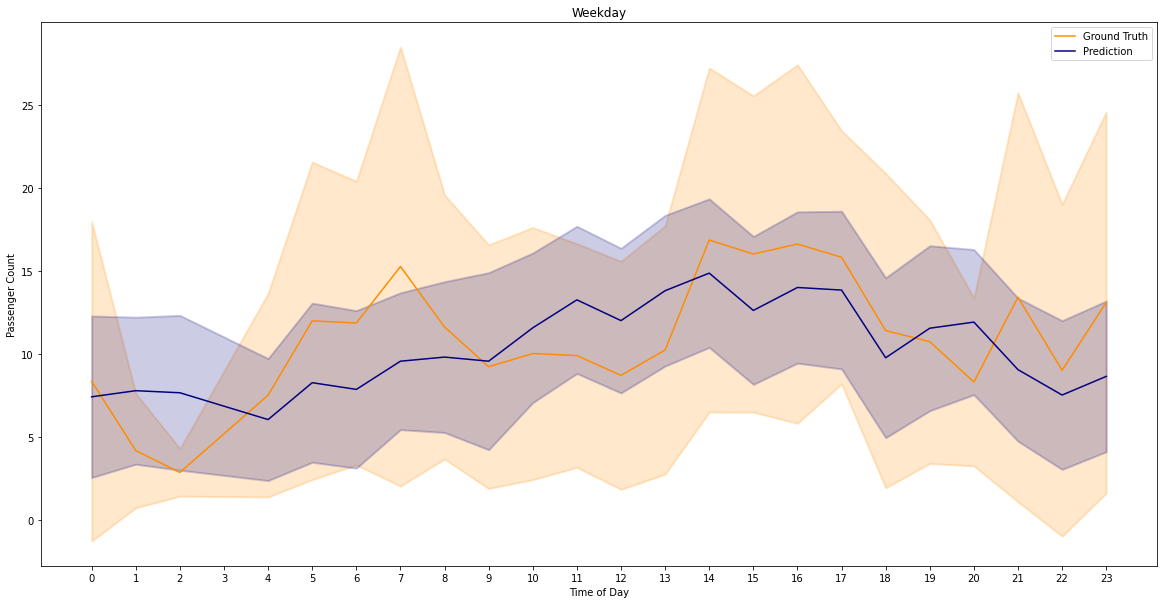

In [ ]:
eval.plot_passenger_count_by_time_of_day('test', dir=None, segment=None, agg='mean')

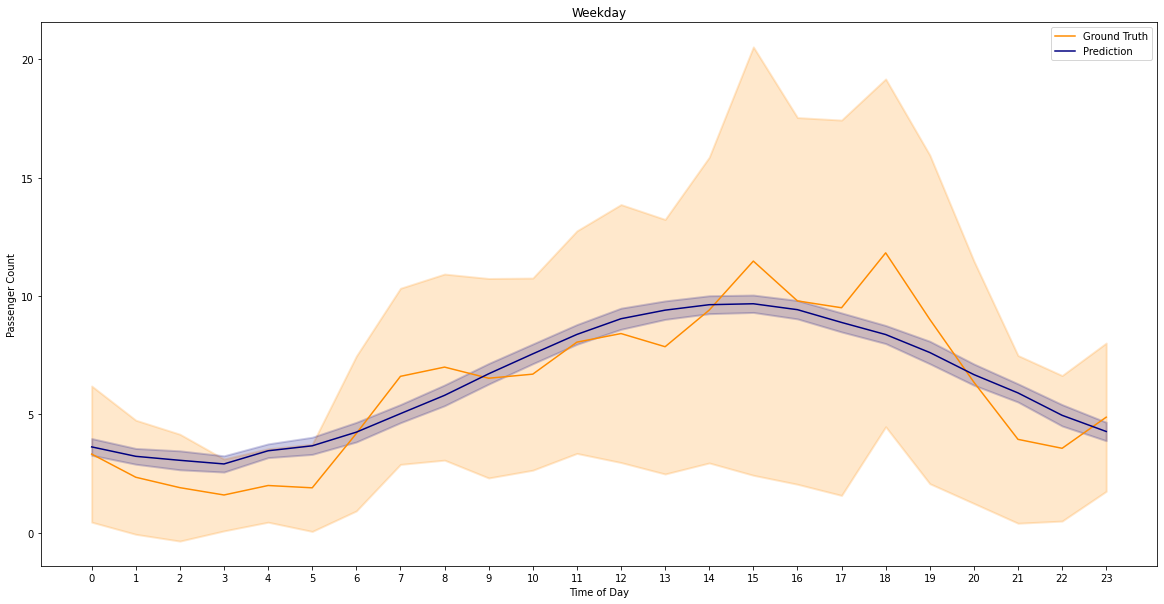

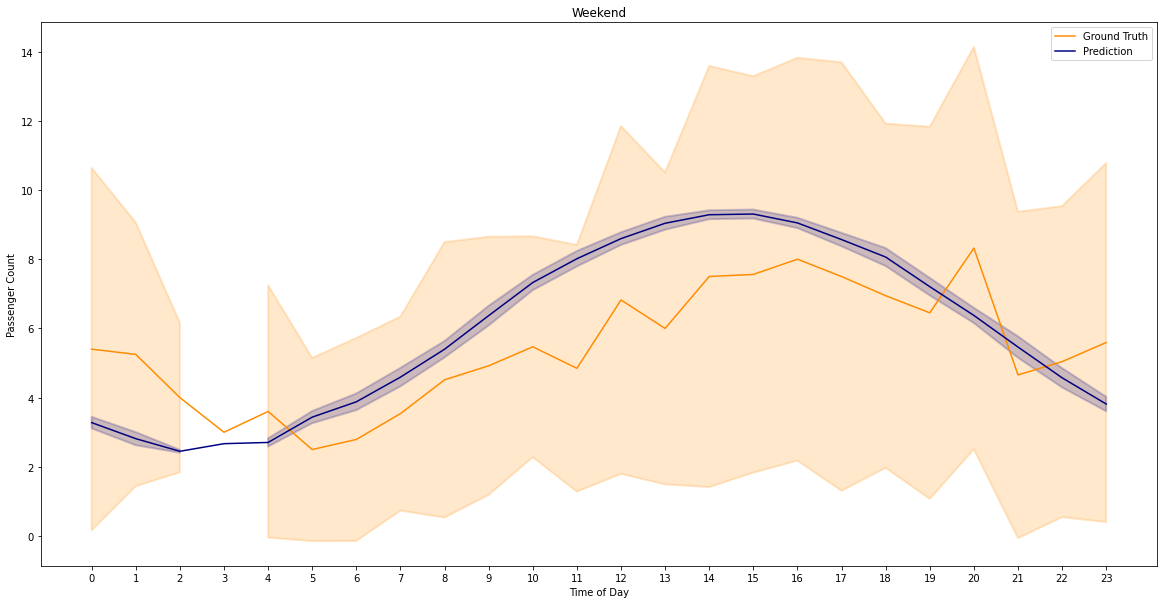

In [ ]:
eval.plot_passenger_count_by_time_of_day('train', dir=1, segment=5, agg='mean')

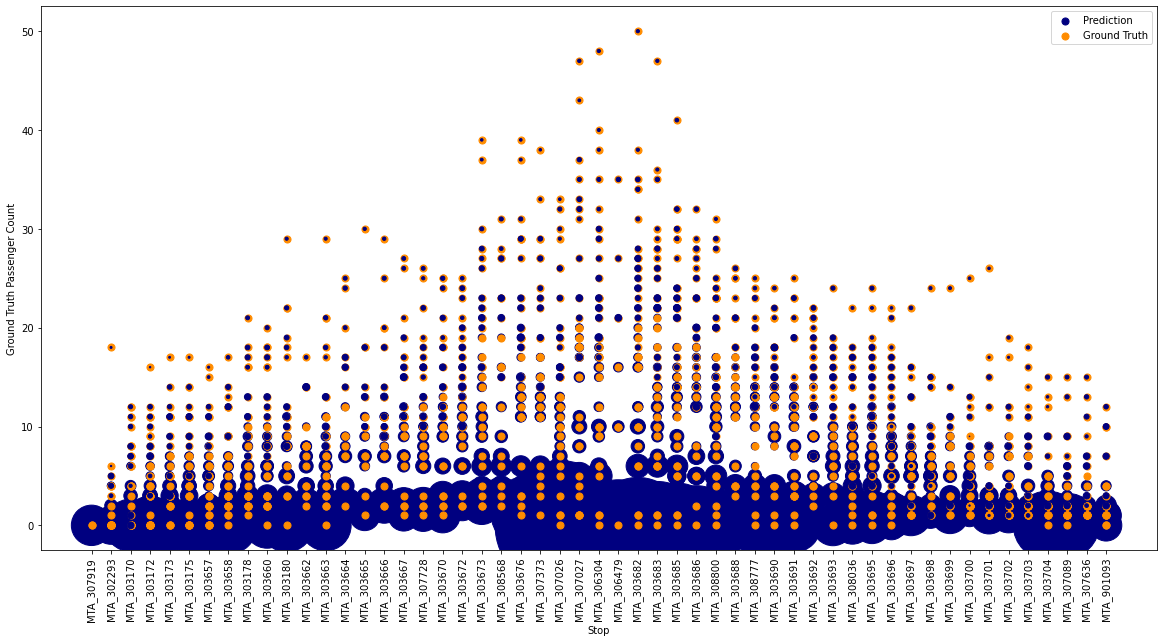

In [ ]:
eval.gt_pred_scatter('test', dir=1, eps=1, s=50, lower=0, upper=None)

todo fixed crowded measure based on bus capacity

In [ ]:
eval.print_classification_metrics('train', num_stds=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92    187581
           1       0.00      0.00      0.00     33207

    accuracy                           0.85    220788
   macro avg       0.42      0.50      0.46    220788
weighted avg       0.72      0.85      0.78    220788



Confusion Matrix (0 = not crowded | 1 = crowded):
[[187580      1]
 [ 33207      0]]


In [ ]:
eval.print_classification_metrics('train', num_stds=0.5)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85    163843
           1       0.46      0.04      0.08     56945

    accuracy                           0.74    220788
   macro avg       0.60      0.51      0.46    220788
weighted avg       0.67      0.74      0.65    220788



Confusion Matrix (0 = not crowded | 1 = crowded):
[[160864   2979]
 [ 54441   2504]]
